# 2025 데이터 크리에이터 캠프

@PHASE: Mission 2

@TEAM: 최후의 인공지능

## 1. Check GPU Availability

- GPU 번호 지정

In [1]:
!nvidia-smi

Tue Oct 14 21:47:00 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   40C    P8              35W / 300W |   2119MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Set CUDA Device Number
DEVICE_NUM = 0

from os import environ
environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_NUM)

## 2. Imports

- 의존성 로드

In [3]:
import random
import os
import gc

import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import matplotlib.pyplot as plt
from transformers.utils.notebook import NotebookProgressBar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"INFO: Using device - {device}")

INFO: Using device - cuda


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
set_seed()  # 시드 고정

## 3. Define Dataset

- 데이터셋 정의

### 3.1. 데이터셋 홀더 클래스 생성

In [6]:
from dataclasses import dataclass


@dataclass
class DatasetHolder:
    train: Dataset = None
    valid: Dataset = None
    test: Dataset = None

    def __post_init__(self):
        print(f"INFO: Dataset loaded successfully. Number of samples - ", end='')
        if self.train:
            print(f"Train: {len(self.train)}", end='')
        if self.valid:
            if self.train: print(', ', end='')
            print(f"Valid: {len(self.valid)}", end='')
        if self.test:
            if self.train: print(', ', end='')
            print(f"Test: {len(self.test)}", end='')
        print('\n')

### 3.2. 데이터셋 클래스 정의

#### 3.2.1. 데이터셋 인덱스 지정

In [7]:
from enum import Enum


# Github Release URL for datasets
# This will be removed after the contest ends due to the copyright issue.
base_git_path = "https://github.com/b-re-w/K-ICT_DataCreatorCamp_2025/releases/download/dt/"


class KompsatIndex(Enum):
    TRAIN = "TS_KS.zip"
    VALID = "VS_KS.zip"
    TRAIN_BBOX = "TL_KS_BBOX.zip"
    VALID_BBOX = "VL_KS_BBOX.zip"
    TRAIN_LINE = "TL_KS_LINE.zip"
    VALID_LINE = "VL_KS_LINE.zip"

    @property
    def url(self):
        return f"{base_git_path}{self.value}"

#### 3.2.2. 목적별 데이터셋 정의

In [8]:
from torchvision.datasets import VisionDataset, utils, folder
from torchvision.ops import box_convert

import traceback
from os import path
from glob import glob
from enum import Enum
from pathlib import Path
from typing import Union, Optional, Callable

from json import load as json_load

from tqdm.asyncio import tqdm
import concurrent.futures
import asyncio

import nest_asyncio
nest_asyncio.apply()


class KompsatType(Enum):
    BBOX = "bbox"
    LINE = "line"


class KompsatDataset(VisionDataset):
    dataset_name = "Kompsat"

    @classmethod
    async def download_method(cls, url, root, filename):
        loop = asyncio.get_event_loop()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            await loop.run_in_executor(executor, utils.download_url, url, root, filename)

    @classmethod
    async def extract_method(cls, from_path, to_path):
        try:
            loop = asyncio.get_event_loop()
            with concurrent.futures.ThreadPoolExecutor() as executor:
                await loop.run_in_executor(executor, utils.extract_archive, from_path, to_path)
        except FileExistsError as e:
            traceback.print_exc()
            raise FileExistsError(str(e) + "\nPlease use Python 3.13 or later. 3.12 or earlier versions not support unzip over existing directory.")

    def __init__(
        self,
        root: Union[str, Path] = None,
        train: bool = True,
        data_type: KompsatType = KompsatType.BBOX,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ):
        """
        Kompsat-3/3A dataset for object detection and height estimation.

        Args:
            root: Dataset root directory
            train: True for training set, False for validation set
            data_type: BBOX or LINE
            transform: Image transforms
            target_transform: Mask transforms
        """
        super().__init__(root, transforms=transform, transform=transform, target_transform=target_transform)

        loop = asyncio.get_event_loop()
        loop.run_until_complete(self.download(root))

        self.root = path.join(root, self.dataset_name)
        self.train = train
        self.data_type = data_type
        split = "train" if train else "val"
        img_dir = path.join(self.root, "images", split)
        ann_dir = path.join(self.root, "annotations", split)
        line_dir = path.join(self.root, "lines", split)

        self.images = sorted(glob(path.join(img_dir, "*.jpg")))
        self.labels = []
        for pth in self.images:
            if data_type is KompsatType.BBOX:
                annotation_path = path.join(ann_dir, Path(pth).stem + ".json")
                if not path.exists(annotation_path):
                    raise FileNotFoundError(f"Annotation file {annotation_path} does not exist.")
                annotation = list(json_load(open(annotation_path, "r", encoding="utf-8")).values())[0]
                regions = []
                for anno in sorted(annotation['regions'], key=lambda x: int(x['region_attributes']['chi_id'])):
                    bbox = anno["shape_attributes"]
                    bbox = [bbox["x"], bbox["y"], bbox["width"], bbox["height"]]
                    regions.append(dict(
                        chi_id=int(anno["region_attributes"]["chi_id"]),
                        xywh=bbox,
                        xyxy=box_convert(torch.tensor(bbox), "xywh", "xyxy").tolist(),
                        cxcywh=box_convert(torch.tensor(bbox), "xywh", "cxcywh").tolist()
                    ))
                annotation['regions'] = regions
                annotation['file_attributes']['img_width'] = int(annotation['file_attributes']['img_width'])
                annotation['file_attributes']['img_height'] = int(annotation['file_attributes']['img_height'])
                self.labels.append(annotation)
            else:
                label_path = path.join(line_dir, Path(pth).stem + ".json")
                if not path.exists(label_path):
                    raise FileNotFoundError(f"Label file {label_path} does not exist.")
                label = list(json_load(open(label_path, "r", encoding="utf-8")).values())[0]
                regions = []
                for ln in sorted(label['regions'], key=lambda x: int(x['region_attributes']['chi_id'])):
                    poly = ln["shape_attributes"]
                    xyxy = [poly["all_points_x"][0], poly["all_points_y"][0], poly["all_points_x"][1], poly["all_points_y"][1]]
                    x1 = max(min(xyxy[0], xyxy[2]) - 1, 0)
                    y1 = max(min(xyxy[1], xyxy[3]) - 1, 0)
                    w = abs(xyxy[2] - xyxy[0]) + 2
                    h = max(abs(xyxy[3] - xyxy[1]), 1) + 2
                    regions.append(dict(
                        polyline=xyxy,
                        xywh=[x1, y1, w, h],
                        chi_height=float(ln["region_attributes"]['chi_height_m']),
                    ))
                label['regions'] = regions
                label['file_attributes']['img_width'] = int(label['file_attributes']['img_width'])
                label['file_attributes']['img_height'] = int(label['file_attributes']['img_height'])
                self.labels.append(label)

        assert len(self.images) == len(self.labels), \
            f"Number of images ({len(self.images)}) and labels ({len(self.labels)}) do not match."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """Get a sample from the dataset"""
        # Load image/label using default_loader
        image = folder.default_loader(self.images[idx])
        label = self.labels[idx]

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    @classmethod
    async def download(cls, root: str):
        dataset_root = path.join(root, cls.dataset_name)
        if path.exists(dataset_root):  # If the dataset directory already exists, skip download
            return

        data_list = [
            KompsatIndex.TRAIN, KompsatIndex.VALID,
            KompsatIndex.TRAIN_BBOX, KompsatIndex.VALID_BBOX,
            KompsatIndex.TRAIN_LINE, KompsatIndex.VALID_LINE
        ]

        print(f"INFO: Downloading '{cls.dataset_name}' from server to {root}...")
        routines = []
        for data in data_list:
            if path.isfile(path.join(root, data.value)):
                print(f"INFO: Dataset archive {data.value} found in the root directory. Skipping download.")
                continue

            routines.append(cls.download_method(data.url, root=root, filename=data.value))
        await tqdm.gather(*routines, desc="Downloading files")

        print(f"INFO: Extracting '{cls.dataset_name}' dataset...")
        routines = []
        img_dir, anno_dir, line_dir = path.join(dataset_root, "images"), path.join(dataset_root, "annotations"), path.join(dataset_root, "lines")
        as_train, as_valid = lambda d: path.join(d, "train"), lambda d: path.join(d, "val")
        routines.extend((
            cls.extract_method(path.join(root, KompsatIndex.TRAIN.value), to_path=as_train(img_dir)),
            cls.extract_method(path.join(root, KompsatIndex.VALID.value), to_path=as_valid(img_dir)),
            cls.extract_method(path.join(root, KompsatIndex.TRAIN_BBOX.value), to_path=as_train(anno_dir)),
            cls.extract_method(path.join(root, KompsatIndex.VALID_BBOX.value), to_path=as_valid(anno_dir)),
            cls.extract_method(path.join(root, KompsatIndex.TRAIN_LINE.value), to_path=as_train(line_dir)),
            cls.extract_method(path.join(root, KompsatIndex.VALID_LINE.value), to_path=as_valid(line_dir)),
        ))
        await tqdm.gather(*routines, desc="Extracting files")


class KompsatDatasetForObjectDetection(KompsatDataset):
    def __init__(
        self,
        root: Union[str, Path] = None,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ):
        super().__init__(root, train, KompsatType.BBOX, transform, target_transform)


class KompsatDatasetForHeightRegression(KompsatDataset):
    def __init__(
        self,
        root: Union[str, Path] = None,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ):
        super().__init__(root, train, KompsatType.LINE, transform, target_transform)

#### 3.2.3. 데이터셋 인스턴스 생성

- Train, Valid

##### 3.2.3.1. 인스턴스 생성

In [9]:
DATA_ROOT = path.join(".", "data")

kompstats = DatasetHolder(
    train=KompsatDatasetForHeightRegression(root=DATA_ROOT, train=True),
    valid=KompsatDatasetForHeightRegression(root=DATA_ROOT, train=False)
)
kompstats.test = kompstats.valid  # test set은 valid set과 동일

INFO: Dataset loaded successfully. Number of samples - Train: 8052, Valid: 1006



In [10]:
# 출력 검증
kompstats.train[0]

(<PIL.Image.Image image mode=RGB size=512x512>,
 {'filename': 'K3A_CHN_20161112052404_0.jpg',
  'size': 63669,
  'regions': [{'polyline': [108, 378, 184, 370],
    'xywh': [107, 369, 78, 10],
    'chi_height': 76.78},
   {'polyline': [221, 402, 284, 394],
    'xywh': [220, 393, 65, 10],
    'chi_height': 63.81}],
  'file_attributes': {'img_id': 'K3A_CHN_20161112052404_0',
   'img_height': 512,
   'img_width': 512,
   'img_resolution': '0.55',
   'img_time': '16111205',
   'img_roll_tilt': '28.6724462424',
   'img_pitch_tilt': '1.3777451834',
   'img_provided': '한국항공우주연구원',
   'provided_nm': '한국지능정보사회진흥원'}})

##### 3.2.3.2 출력 시각화

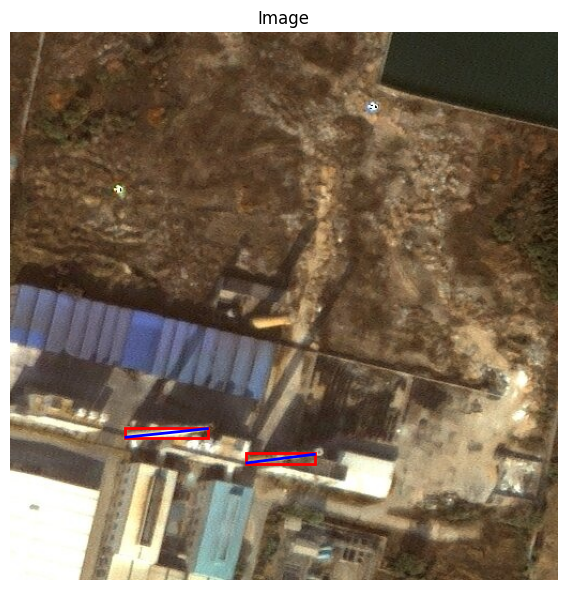

In [11]:
rgb_image, annotation = kompstats.train[0]
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

axes.imshow(rgb_image)
axes.set_title('Image')
axes.axis('off')

for region in annotation['regions']:
    x1, y1, w, h = region['xywh']
    rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=2)
    axes.add_patch(rect)

    polyline = region['polyline']
    xs = [polyline[0], polyline[2]]
    ys = [polyline[1], polyline[3]]
    axes.plot(xs, ys, color='blue', linewidth=2)

plt.tight_layout()
plt.show()

##### 3.2.3.3. 통계 수치 계산

In [12]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)  # 임시 데이터 로더

    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean, std

In [13]:
# train set mean, std 계산
stat_path = os.path.join(DATA_ROOT, "mission2.stat")

if os.path.isfile(stat_path):
    with open(stat_path, "r") as f:
        MEAN = [float(x) for x in f.readline().strip().split(',')]
        STD = [float(x) for x in f.readline().strip().split(',')]
else:
    kompstats.train.transform = transforms.ToTensor()  # 임시 transform
    kompstats.train.target_transform = lambda x: []  # 더미 transform
    MEAN, STD = (x.tolist() for x in calculate_mean_std(kompstats.train))
    with open(stat_path, "w") as f:
        f.write(','.join(map(str, MEAN)) + '\n')
        f.write(','.join(map(str, STD)) + '\n')

print("INFO: Calculated MEAN|STD:", MEAN, STD)

INFO: Calculated MEAN|STD: [0.30120164155960083, 0.271025687456131, 0.27913394570350647] [0.17026042938232422, 0.1617444008588791, 0.1593783050775528]


##### 3.2.3.3. Transform 적용

In [ ]:
# Image Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Metadata Transform 정의
def target_transform(data):
    regions = data['regions']
    polylines = []
    heights = []
    for region in regions:
        polyline = region['polyline']
        height = region['chi_height']
        polylines.append(polyline)
        heights.append(height)
    return torch.tensor(polylines), torch.tensor(heights)

In [15]:
# Transform을 데이터셋에 적용
kompstats.train.transform = transform
kompstats.valid.transform = transform
kompstats.train.target_transform = target_transform
kompstats.valid.target_transform = target_transform

In [16]:
# 출력 테스트
kompstats.train[0]

(tensor([[[ 4.4588e-03, -1.3374e-01, -1.8574e-02,  ..., -8.0169e-01,
           -7.5562e-01, -8.0169e-01],
          [-1.1071e-01, -1.3374e-01,  1.4266e-01,  ..., -7.7866e-01,
           -7.7866e-01, -8.7079e-01],
          [-4.1607e-02, -1.1071e-01,  9.6590e-02,  ..., -6.6349e-01,
           -7.0956e-01, -8.2472e-01],
          ...,
          [ 4.1043e+00,  4.1043e+00,  4.1043e+00,  ...,  1.3864e+00,
            1.3634e+00,  1.2482e+00],
          [ 4.1043e+00,  4.1043e+00,  4.1043e+00,  ...,  1.3173e+00,
            1.2943e+00,  1.2482e+00],
          [ 4.1043e+00,  4.1043e+00,  4.1043e+00,  ...,  1.4095e+00,
            1.4095e+00,  1.4095e+00]],
 
         [[-3.4214e-01, -4.8761e-01, -3.6639e-01,  ..., -5.1186e-01,
           -4.6337e-01, -5.1186e-01],
          [-4.6337e-01, -4.8761e-01, -1.9667e-01,  ..., -4.8761e-01,
           -4.8761e-01, -5.8460e-01],
          [-3.9063e-01, -4.6337e-01, -2.4516e-01,  ..., -3.6639e-01,
           -4.1488e-01, -5.3610e-01],
          ...,
    

## 4. DataLoader

- 데이터 로더 생성
- A6000 기준 배치 크기
- 일반화 성능 위해 큰 배치 크기 사용 (배치 크기 변경시 Gradient Accumulation 필요)

In [17]:
# Set Batch Size
BATCH_SIZE = 64, 128, 128

print(f"INFO: Set batch size - Train: {BATCH_SIZE[0]}, Valid: {BATCH_SIZE[1]}, Test: {BATCH_SIZE[2]}")

INFO: Set batch size - Train: 64, Valid: 128, Test: 128


In [18]:
# Collate 함수 지정
# image와 bbox를 입력 데이터로, height를 라벨로
def collate_fn(batch):
    images, labels = zip(*batch)
    coords, heights = zip(*labels)
    return torch.stack(images), coords, heights

In [19]:
train_loader = DataLoader(kompstats.train, batch_size=BATCH_SIZE[0], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(kompstats.valid, batch_size=BATCH_SIZE[1], shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(kompstats.test, batch_size=BATCH_SIZE[2], shuffle=False, collate_fn=collate_fn)

## 5. Define Model

- 모델 정의

In [20]:
class GeometricPriorityRegression(nn.Module):
    def __init__(self, img_size=224):
        super().__init__()
        self.img_size = img_size

        # 기하학적 높이 예측기 (메인)
        self.geometric_predictor = nn.Sequential(
            nn.Linear(4, 64),     # [pixel_dist, norm_dist, angle, aspect_ratio]
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)      # 기하학적 높이 추정
        )

        # 이미지 맥락 보정기 (보조)
        self.image_encoder = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        self.image_encoder.fc = nn.Linear(self.image_encoder.fc.in_features, 128)

        # 최종 보정기 (기하학적 결과를 미세 조정)
        self.corrector = nn.Sequential(
            nn.Linear(128 + 1, 64),  # 이미지 특징 + 기하학적 높이
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)         # 보정값 출력
        )

    def calculate_geometric_features(self, polyline):
        """핵심 기하학적 특징 계산"""
        batch_size = polyline.shape[0]
        features = torch.zeros(batch_size, 4, device=polyline.device)

        for i in range(batch_size):
            kpt_x1, kpt_y1, kpt_x2, kpt_y2 = polyline[i]

            # 픽셀 거리
            pixel_distance = torch.sqrt((kpt_x2 - kpt_x1)**2 + (kpt_y2 - kpt_y1)**2)

            # 정규화된 거리
            diagonal = torch.sqrt(torch.tensor(2 * self.img_size**2, device=polyline.device))
            normalized_distance = pixel_distance / diagonal

            # 각도
            angle = torch.atan2(kpt_y2 - kpt_y1, kpt_x2 - kpt_x1)

            # 종횡비
            height_diff = torch.abs(kpt_y2 - kpt_y1)
            width_diff = torch.abs(kpt_x2 - kpt_x1)
            aspect_ratio = height_diff / (width_diff + 1e-8)

            features[i] = torch.stack([pixel_distance, normalized_distance, angle, aspect_ratio])

        return features

    def forward(self, pixel_values, polylines):
        # 이미지 전역 특징 (맥락 정보)
        image_features = self.image_encoder(pixel_values.to(device))
        results = []

        for hidden_states, polyline in zip(image_features, polylines):
            hidden_states = hidden_states.unsqueeze(0)
            if polyline.shape[0] > 1:
                hidden_states = hidden_states.expand(polyline.shape[0], -1)

            # 1. 기하학적 특징 계산 및 높이 추정 (메인)
            geometric_features = self.calculate_geometric_features(polyline.float().to(device))
            geometric_height = self.geometric_predictor(geometric_features)

            # 2. 이미지 맥락을 통한 보정 (보조)
            correction_input = torch.cat((hidden_states, geometric_height), dim=1)
            correction = self.corrector(correction_input)

            # 3. 최종 높이 = 기하학적 높이 + 보정값
            final_height = geometric_height + correction

            results.append(final_height.reshape(-1))

        return results

In [21]:
# 모델 생성
torch.cuda.empty_cache()
gc.collect()

set_seed(20251001)
model = GeometricPriorityRegression(img_size=224)
model.to(device)

GeometricPriorityRegression(
  (geometric_predictor): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(6

## 6. Train

- Epoch 기반 학습 진행
- 이상치에 강인하도록 HuberLoss 사용
- CyclicLR을 사용하여 정기적으로 LR 증가

In [ ]:
set_seed(2025)

EPOCHS = 200
LEARNING_RATE = 1e-4, 1e-5

classifier = nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE[0])
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LEARNING_RATE[1], max_lr=LEARNING_RATE[0], step_size_up=50, gamma=0.95)
optimizer.param_groups[0]['lr'] = LEARNING_RATE[0]

In [23]:
set_seed(20251001)

total_bar = NotebookProgressBar(EPOCHS, prefix="Running Epochs")
for epoch in range(EPOCHS):
    total_bar.update(epoch+1)
    train_loss, valid_loss = [], []
    train_rmse, valid_rmse = [], []

    model.train()
    train_bar = NotebookProgressBar(int(len(kompstats.train)/BATCH_SIZE[0]+0.99), prefix=f"Training {epoch+1}")
    for i, (inputs, coords, heights) in enumerate(train_loader):
        optimizer.zero_grad()

        preds = model(inputs, coords)
        all_preds = torch.cat([pred.flatten() for pred in preds])
        all_heights = torch.cat([height.flatten() for height in heights]).to(device).to(all_preds.dtype)

        losses = classifier(all_preds, all_heights)
        losses.backward()

        rmse = torch.sqrt(nn.functional.mse_loss(all_preds, all_heights)).item()
        if rmse >= 1000 or (epoch >= 50 and rmse >= 10):  # 이상치 로스 업데이트 안함
            optimizer.zero_grad()  # gradient 제거
        else:
            optimizer.step()  # gradient 반영
            train_loss.append(losses.item())
            train_rmse.append(rmse)

        if i+1 != train_bar.total: train_bar.update(i+1, comment=f"Loss={losses.item():.6f}, RMSE(m)={rmse:.3f}, LR={optimizer.param_groups[0]['lr']:.1e}")
    train_bar.update(train_bar.total, comment=f"Loss={sum(train_loss)/len(train_loss):.6f}, RMSE(m)={sum(train_rmse)/len(train_rmse):.3f}, LR={optimizer.param_groups[0]['lr']:.1e}")

    model.eval()
    valid_bar = NotebookProgressBar(int(len(kompstats.valid)/BATCH_SIZE[1]+0.99), prefix=f"Validating {epoch+1}")
    with torch.inference_mode():
        for i, (inputs, coords, heights) in enumerate(valid_loader):
            preds = model(inputs, coords)
            all_preds = torch.cat([pred.flatten() for pred in preds])
            all_heights = torch.cat([height.flatten() for height in heights]).to(device).to(all_preds.dtype)

            losses = classifier(all_preds, all_heights)
            rmse = torch.sqrt(nn.functional.mse_loss(all_preds, all_heights))

            valid_loss.append(losses.item())
            valid_rmse.append(rmse.item())
            if i+1 != valid_bar.total: valid_bar.update(i+1, comment="")

    valid_bar.update(valid_bar.total, comment=f"Loss={sum(valid_loss)/len(valid_loss):.6f}, RMSE(m)={sum(valid_rmse)/len(valid_rmse):.3f}")

    scheduler.step()

In [ ]:
# 중간 결과 저장
os.makedirs("./results/", exist_ok=True)
save_path = f"./results/mission_2__temp.pt"
torch.save(model.state_dict(), save_path)
print("INFO: Final model saved to", save_path)  # 7.539049565792084

INFO: Final model saved to ./results/mission_2__temp.pt


### 6.2. Train Phase 2

- 2단계 학습
- 정밀하게 수렴하기 위해 작은 에폭으로 추가 학습 진행

In [91]:
model.load_state_dict(torch.load("./results/mission_2__temp.pt"))

<All keys matched successfully>

In [ ]:
set_seed(2025)

EPOCHS = 60
LEARNING_RATE = 1e-4, 1e-5

classifier = nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE[0])
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LEARNING_RATE[1], max_lr=LEARNING_RATE[0], step_size_up=50, gamma=0.95)

In [93]:
set_seed(20251001)

total_bar = NotebookProgressBar(EPOCHS, prefix="Running Epochs")
for epoch in range(EPOCHS):
    total_bar.update(epoch+1)
    train_loss, valid_loss = [], []
    train_rmse, valid_rmse = [], []

    model.train()
    train_bar = NotebookProgressBar(int(len(kompstats.train)/BATCH_SIZE[0]+0.99), prefix=f"Training {epoch+1}")
    for i, (inputs, coords, heights) in enumerate(train_loader):
        optimizer.zero_grad()

        preds = model(inputs, coords)
        all_preds = torch.cat([pred.flatten() for pred in preds])
        all_heights = torch.cat([height.flatten() for height in heights]).to(device).to(all_preds.dtype)

        losses = classifier(all_preds, all_heights)
        losses.backward()

        rmse = torch.sqrt(nn.functional.mse_loss(all_preds, all_heights)).item()
        if rmse >= 1000 or (epoch >= 50 and rmse >= 10):  # 이상치 로스 업데이트 안함
            optimizer.zero_grad()  # gradient 제거
        else:
            optimizer.step()  # gradient 반영
            train_loss.append(losses.item())
            train_rmse.append(rmse)

        if i+1 != train_bar.total: train_bar.update(i+1, comment=f"Loss={losses.item():.6f}, RMSE(m)={rmse:.3f}, LR={optimizer.param_groups[0]['lr']:.1e}")
    train_bar.update(train_bar.total, comment=f"Loss={sum(train_loss)/len(train_loss):.6f}, RMSE(m)={sum(train_rmse)/len(train_rmse):.3f}, LR={optimizer.param_groups[0]['lr']:.1e}")

    model.eval()
    valid_bar = NotebookProgressBar(int(len(kompstats.valid)/BATCH_SIZE[1]+0.99), prefix=f"Validating {epoch+1}")
    with torch.inference_mode():
        for i, (inputs, coords, heights) in enumerate(valid_loader):
            preds = model(inputs, coords)
            all_preds = torch.cat([pred.flatten() for pred in preds])
            all_heights = torch.cat([height.flatten() for height in heights]).to(device).to(all_preds.dtype)

            losses = classifier(all_preds, all_heights)
            rmse = torch.sqrt(nn.functional.mse_loss(all_preds, all_heights))

            valid_loss.append(losses.item())
            valid_rmse.append(rmse.item())
            if i+1 != valid_bar.total: valid_bar.update(i+1, comment="")

    valid_bar.update(valid_bar.total, comment=f"Loss={sum(valid_loss)/len(valid_loss):.6f}, RMSE(m)={sum(valid_rmse)/len(valid_rmse):.3f}")
    torch.save(model.state_dict(), f"./results/mission_2__phase2_ep{epoch}.pt")

    scheduler.step()

In [ ]:
# 중간 결과 저장
os.makedirs("./results/", exist_ok=True)
save_path = f"./results/mission_2__temp2.pt"
torch.save(model.state_dict(), save_path)
print("INFO: Final model saved to", save_path)

INFO: Final model saved to ./results/mission_2__temp2.pt


In [ ]:
model.load_state_dict(torch.load("results/mission_2__temp2.pt"))

<All keys matched successfully>

## 7. Evaluate

- 최종 성능 확인 및 모델 저장

In [105]:
def evaluate(model: nn.Module, data_loader: DataLoader, data_loader_len: int):
    model.eval()
    total_rmse = []

    with torch.no_grad():
        total_bar = NotebookProgressBar(data_loader_len, prefix="Final Testing..")
        for i, (inputs, coords, heights) in enumerate(data_loader):
            preds = model(inputs, coords)
            all_preds = torch.cat([pred.flatten() for pred in preds])
            all_heights = torch.cat([height.flatten() for height in heights]).to(device).to(all_preds.dtype)

            rmse = torch.sqrt(nn.functional.mse_loss(all_preds, all_heights))
            total_rmse.append(rmse.item())
            total_bar.update(i+1)

    return sum(total_rmse) / len(total_rmse)

In [106]:
print("\n=== Final Evaluation ===")
test_loader_len = int(len(kompstats.test)/BATCH_SIZE[2]+0.99)
test_rmse = evaluate(model, test_loader, test_loader_len)
print(f"INFO: Test RSME - {test_rmse}m")


=== Final Evaluation ===


INFO: Test RSME - 7.1725868582725525m


In [107]:
os.makedirs("./results/", exist_ok=True)
save_path = f"./results/mission_2__rsme_{test_rmse}.pt"
torch.save(model.state_dict(), save_path)
print("INFO: Final model saved to", save_path)

INFO: Final model saved to ./results/mission_2__rsme_7.1725868582725525.pt


In [108]:
# 모델 정상 저장 확인
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>